In [1]:
import pickle
# from sklearn.neural_network import MLPRegressor
from mapie.regression import MapieRegressor
from matplotlib import pyplot as plt
from mapie.metrics import regression_coverage_score
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../..')) # this is the ml_dadi dir
import ml_models
# import plotting
from ml_models import r2, rho
from plotting import plot_accuracy_single
import math
import numpy as np

In [4]:
# # load data
# train_data = pickle.load(open('data/1d_2epoch/train_data_10000','rb'))
# test_data = pickle.load(open('data/1d_2epoch/test_data','rb'))

In [5]:
# # unpack train data set
# # fs
# X_train = [train_data[params].data.flatten()
#            for params in train_data]
# # params
# y_train = [params for params in train_data]
# # separate each param
# N_train = [params[0] for params in y_train]
# t_train = [params[1] for params in y_train]
# # theta_train = [params[2] for params in y_train]

In [8]:
# # training mapie regressors
# mlpr = MLPRegressor(hidden_layer_sizes=(500,),
#                             activation='tanh', solver='adam',
#                             max_iter=5000)

# # for N
# mapie_N = MapieRegressor(mlpr)
# mapie_N.fit(X_train, N_train)
# # for t
# mapie_t = MapieRegressor(mlpr)
# mapie_t.fit(X_train, t_train)
# # # for theta
# # mapie_theta = MapieRegressor(mlpr)
# # mapie_theta.fit(X_train, theta_train)

MapieRegressor(estimator=MLPRegressor(activation='tanh',
                                      hidden_layer_sizes=(500,),
                                      max_iter=5000))

In [9]:
# pickle.dump(mapie_N, open('data/1d_2epoch/mapie_N', 'wb'), 2)
# pickle.dump(mapie_t, open('data/1d_2epoch/mapie_t', 'wb'), 2)

In [27]:
# load trained regressors and test data
# test_data = pickle.load(open('data/test_data_full','rb'))
# test_data = pickle.load(open('data/test_data_new','rb'))
test_data = pickle.load(open('data/test_data_new_not_sampled','rb'))
# test_data = pickle.load(open('data/train_data_10000','rb'))
# mapie_N = pickle.load(open('data/mapie_N','rb'))
# mapie_t = pickle.load(open('data/mapie_t','rb'))
mapie_N = pickle.load(open('data/mapie_N_10k','rb'))
mapie_t = pickle.load(open('data/mapie_t_10k','rb'))

In [47]:
# unpack test data set
theta_i = 3
theta_list = [100000, 10000, 1000, 100]
X_test = [test_data[theta_i][params].data.flatten()
          for params in test_data[theta_i]]
y_test = [params for params in test_data[theta_i]]
# separate each param
N_test = [params[0] for params in y_test]
t_test = [params[1] for params in y_test]

In [48]:
# implementing MAPIE test
alpha = [0.05, 0.1, 0.2, 0.5, 0.7, 0.85]
# for nu
N_pred, N_pis = mapie_N.predict(X_test, alpha=alpha)
# for T
t_pred, t_pis = mapie_t.predict(X_test, alpha=alpha)

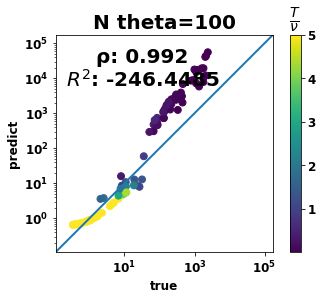

In [49]:
t_over_2N = [10**t/(2*(10**N)) for t,N in zip(t_test, N_test)]

N_test_log = [10**p_true for p_true in N_test]
N_pred_log = [10**p_pred for p_pred in N_pred]

r2 = ml_models.r2(N_test_log, N_pred_log)[0]
rho = ml_models.rho(N_test_log, N_pred_log)

plot_accuracy_single(N_test_log, N_pred_log, x_label="true",
                         y_label="predict", size=[6, 2, 20], log=True, r2=r2, rho=rho, title = 'N ' + f'theta={theta_list[theta_i]}', c=t_over_2N)

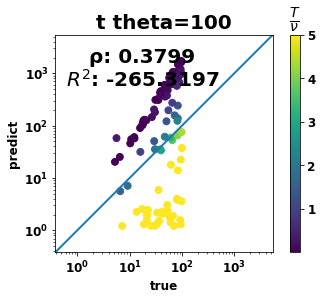

In [50]:
t_test_log = [10**p_true for p_true in t_test]
t_pred_log = [10**p_pred for p_pred in t_pred]

r2 = ml_models.r2(t_test_log, t_pred_log)[0]
rho = ml_models.rho(t_test_log, t_pred_log)

plot_accuracy_single(t_test_log, list(t_pred_log), size=[6, 2, 20], log=True, r2=r2, rho=rho, title = 't ' + f'theta={theta_list[theta_i]}', c=t_over_2N)

In [51]:
# coverage score by params
N_coverage_scores = [
    regression_coverage_score(N_test, N_pis[:, 0, i], N_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

t_coverage_scores = [
    regression_coverage_score(t_test, t_pis[:, 0, i], t_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]


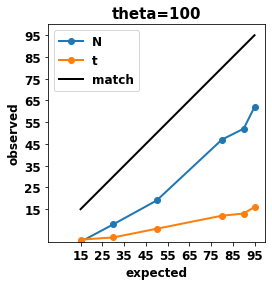

In [52]:
# plot coverage

expected = [95, 90, 80, 50, 30, 15]
params = ['N', 't']

observed = ([s*100 for s in N_coverage_scores],
            [s*100 for s in t_coverage_scores])

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
font = {'weight': 'bold', 'size': 12}
plt.rc('font', **font)

ax.set_title(f'theta={theta_list[theta_i]}', fontsize=15, fontweight='bold')
ax.set_xlabel("expected", fontsize=12, fontweight='bold')
ax.set_ylabel("observed", fontsize=12, fontweight='bold')

for i in range(len(params)):
    ax.plot(expected, observed[i],
            label=params[i], marker='o', linewidth=2)
ax.plot(expected, expected, label='match', linewidth=2, color="black")

plt.xticks(np.arange(min(expected), max(expected)+5, 10))
plt.yticks(np.arange(min(expected), max(expected)+5, 10))
plt.xlim([0, 100])
plt.ylim([0, 100])

ax.legend()

In [44]:
# plot 95% confidence interval
params = ['N', 't']
N_arr = np.array([N_test, N_pred, N_pis[:, 0, 0], N_pis[:, 1, 0]])
t_arr = np.array([t_test, t_pred, t_pis[:, 0, 0], t_pis[:, 1, 0]])
# sort by param
int_arr_all = [N_arr.T.tolist(), t_arr.T.tolist()] # differs from Connie bootstrapping version: [true, pred, lower, upper]
size = 100
x = range(size)


color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.

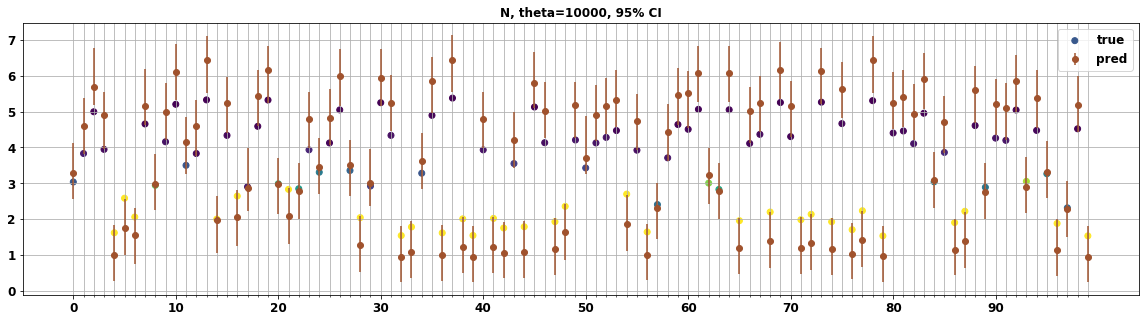

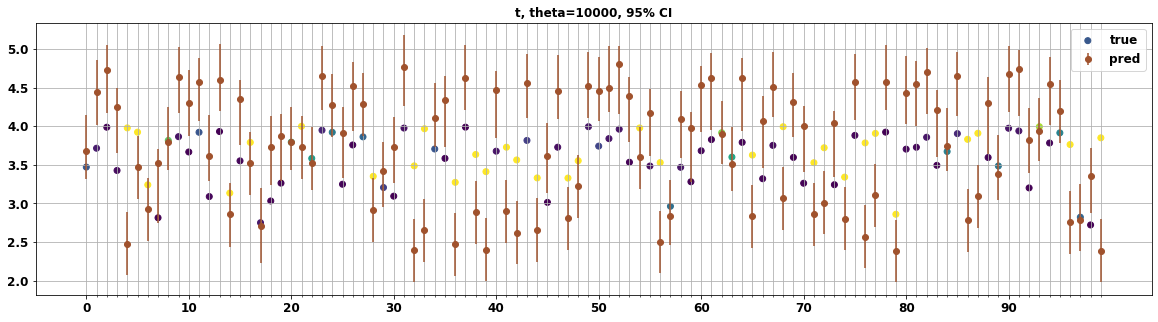

In [28]:
# plot 95% confidence interval (cont.)
for param, int_arr in zip(params, int_arr_all):
    int_arr = np.array(int_arr[:size])
    int_arr = int_arr.transpose(1, 0)

    fig = plt.figure(figsize=(20, 5))
    # ax = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    minor_ticks = np.arange(0, size)
    major_ticks = np.arange(0, size, 10)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')

    # ax.scatter(x, int_arr[0], c="red", label="true")
    ax.scatter(x, int_arr[0], c=t_over_2N, vmax=5, label="true")
    neg_int = int_arr[1] - int_arr[2]
    pos_int = int_arr[3] - int_arr[1]
    ax.errorbar(x, int_arr[1], yerr=[
                neg_int, pos_int], fmt='bo', label = 'pred', c="sienna")

    ax.set_title(f'{param}, theta={theta_list[theta_i]}, 95% CI', fontsize=12, fontweight='bold')
    ax.legend()